In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as pl
import warnings

In [2]:
az.style.available

['fast',
 'seaborn-poster',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'seaborn-deep',
 'Solarize_Light2',
 'seaborn-paper',
 'seaborn-white',
 'seaborn-colorblind',
 '_classic_test',
 'seaborn-pastel',
 'seaborn-bright',
 'ggplot',
 'seaborn-darkgrid',
 'seaborn-muted',
 'grayscale',
 'seaborn-dark',
 'seaborn',
 'seaborn-dark-palette',
 'seaborn-talk',
 'seaborn-notebook',
 'classic',
 'tableau-colorblind10',
 'seaborn-ticks',
 'dark_background',
 'bmh',
 'arviz-colors',
 'arviz-darkgrid',
 'arviz-white',
 'arviz-whitegrid']

In [11]:
az.style.use('arviz-darkgrid')

In [4]:
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'pymc3: {pm.__version__}')
print(f'arviz: {az.__version__}')

pandas: 0.24.2
numpy: 1.16.2
pymc3: 3.6
arviz: 0.4.0


In [4]:
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline

In [6]:
df_stats = pd.read_csv('./Data/Reference_sp_Rrs_AMT_stats_std.csv')
df_stats.set_index('Band', inplace=True)
df_stats.head()

,mPeuk,mPro_border,mPro_gyre,mSyn,sdPeuk,sdPro_border,sdPro_gyre,sdSyn
Band,,,,,,,,
420,1.500850,1.617572,1.980188,1.441588,0.229774,0.051435,0.067358,0.039750
422,1.485130,1.617656,1.959411,1.413814,0.185170,0.043093,0.066532,0.025162
424,1.454370,1.599990,1.918321,1.396227,0.173584,0.038181,0.062649,0.003483
426,1.399284,1.582252,1.875811,1.374741,0.155619,0.037169,0.060243,0.004756
428,1.361316,1.570379,1.841327,1.347966,0.146860,0.034956,0.056601,0.013572


In [7]:
# Numbers of replicates for the table above
Replicates = dict(mPeuk=3, mPro_border=3, mPro_gyre=4, mSyn=2)

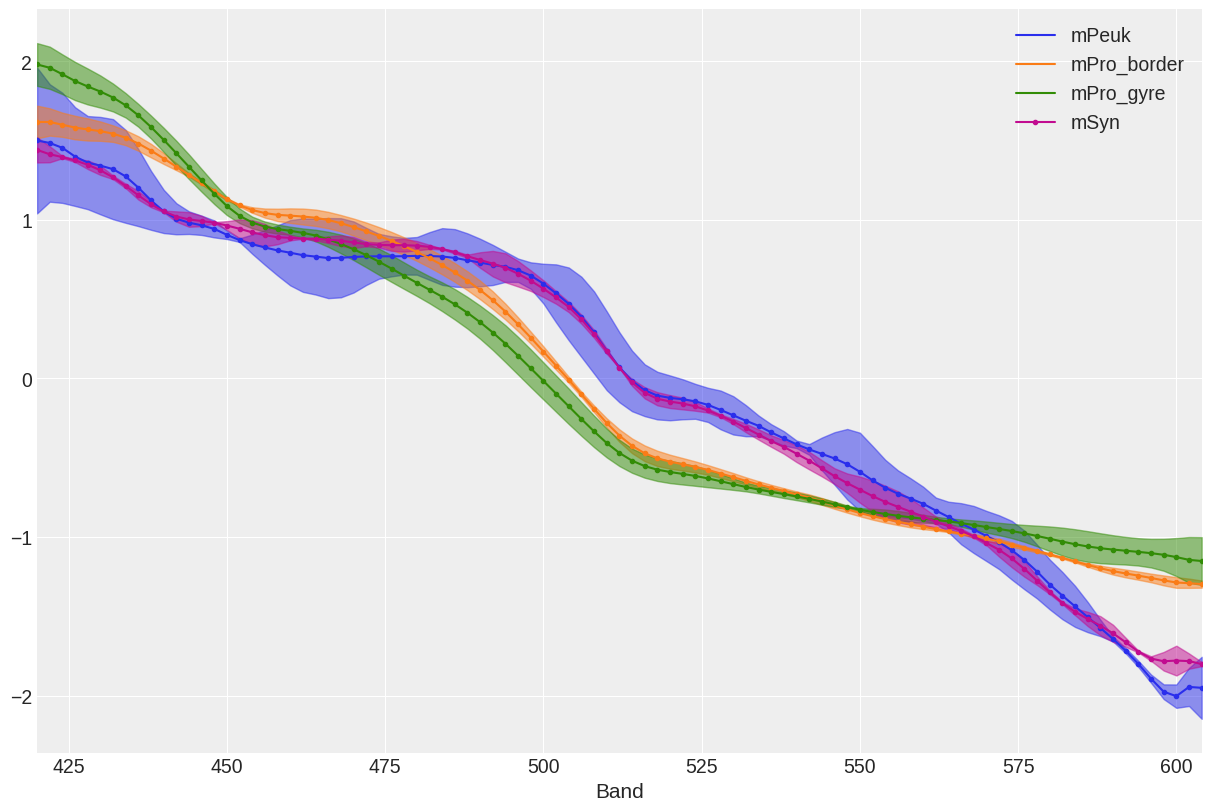

In [12]:
colors = ['C0','C1','C2', 'C3']
critters = ['Peuk', 'Pro_border', 'Pro_gyre', 'Syn']
f, ax = pl.subplots(figsize=(12, 8), constrained_layout=True)
for col, crit in zip(colors, critters):
    df_stats.plot(y=f'm{crit}', color=col, marker='.', ax=ax)
    ax.fill_between(df_stats.index,
                    df_stats[f'm{crit}'] + 2 * df_stats[f'sd{crit}'],
                    df_stats[f'm{crit}'] - 2 * df_stats[f'sd{crit}'],
                   color=col, alpha=0.5)

In [9]:
df_raw = pd.read_csv('./Data/Reference_sp_Rrs_AMT_all_raw.csv')
df_raw.set_index('Band', inplace=True)
df_raw.head()

,Peuk1,Peuk2,Peuk3,Pro_border1,Pro_border2,Pro_border3,Pro_gyre1,Pro_gyre2,Pro_gyre3,Pro_gyre4,Syn1,Syn2
Band,,,,,,,,,,,,
414,0.003551,0.004659,0.004640,0.009113,0.008130,0.009514,0.016274,0.017991,0.013517,0.012196,0.004865,0.004630
416,0.003488,0.004570,0.004542,0.009052,0.008095,0.009436,0.016169,0.017875,0.013301,0.012064,0.004789,0.004534
418,0.003397,0.004478,0.004473,0.009005,0.008062,0.009347,0.016028,0.017698,0.013103,0.011976,0.004736,0.004461
420,0.003321,0.004446,0.004467,0.008983,0.008059,0.009295,0.015899,0.017562,0.012956,0.011871,0.004677,0.004416
422,0.003247,0.004432,0.004482,0.008969,0.008066,0.009259,0.015775,0.017439,0.012827,0.011765,0.004620,0.004383


In [10]:
np.unique(np.diff(df_raw.index.values))

array([2])

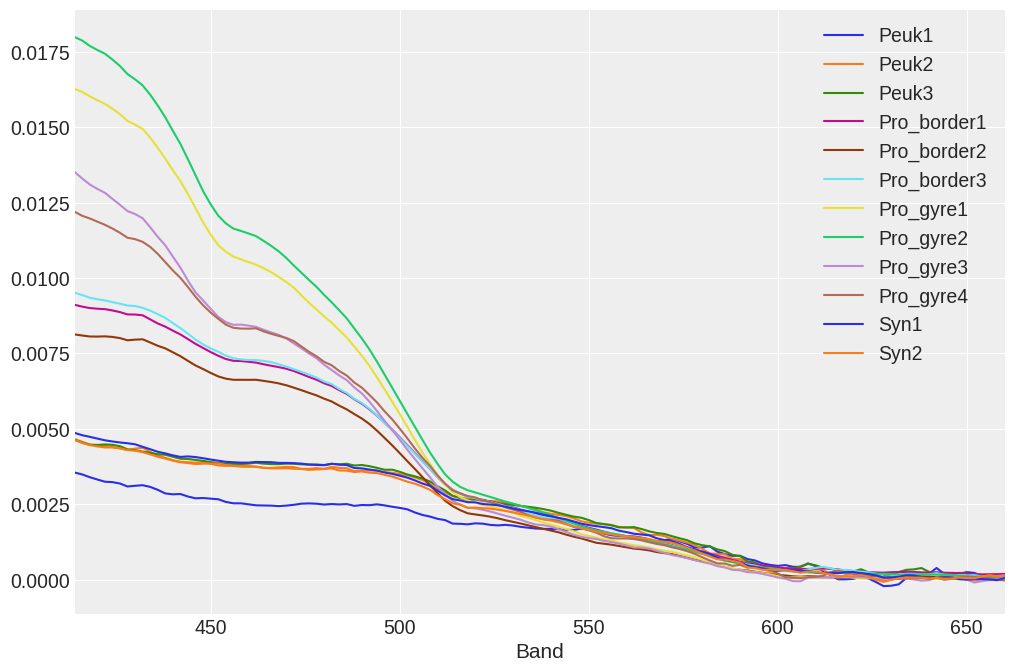

In [13]:
df_raw.plot(figsize=(12, 8));

In [14]:
x = df_stats.index.values[:, None]
X = x-x.min()
yPeuk = df_stats.mPeuk.values
X_ = X[:10]
y_ = yPeuk[:10]

In [15]:
with pm.Model() as peuk_mdl:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instantiate covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instantiate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    #prior
    ϵ = pm.HalfNormal('ϵ', 1)
    # likelihood
    y_peuk = gp.marginal_likelihood('y_pred', X=X_, y=y_, noise=ϵ)

/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [16]:
render = pm.model_to_graphviz(peuk_mdl)
render.format = 'png'
render.render('peuk_mdl', directory='./')

'./peuk_mdl.png'

<img src='./peuk_mdl.png' />

In [17]:
with peuk_mdl:
    trace_peuk = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Usin

In [19]:
from matplotlib import __version__ as mpl_ver

In [20]:
print(mpl_ver)

3.1.0


/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 1013 missing from current font.
  font.set_text(s, 0.0, flags=flags)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe423153a20>,
      dtype=object)

/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 1013 missing from current font.
  font.load_char(ord(s), flags=flags)


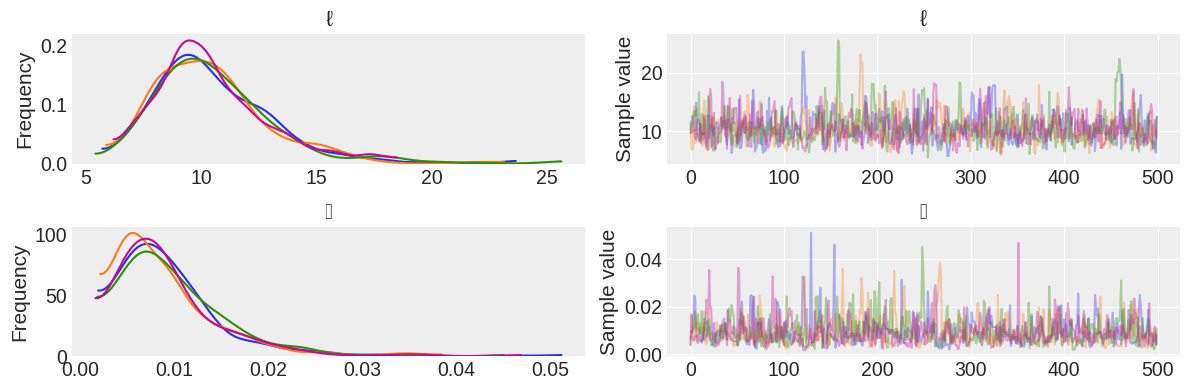

In [18]:
pm.traceplot(trace_peuk)

In [15]:
prior = pm.sample_prior_predictive(model=peuk_mdl)

/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [16]:
ppc = pm.sample_posterior_predictive(trace_peuk, model=peuk_mdl)

  0%|          | 0/2000 [00:00<?, ?it/s]/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
100%|██████████| 2000/2000 [00:02<00:00, 708.03it/s]


In [40]:
df_trace_euk = pm.trace_to_dataframe(trace_peuk, varnames=['ℓ'])

In [17]:
peuk_inference = az.from_pymc3(prior=prior, posterior_predictive=ppc,
                               trace=trace_peuk)

/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


ValueError: zero-dimensional arrays cannot be concatenated

#### Simulate mixed response assuming linear combination as below:

$$Rrs_{bulk} =\alpha_{mPeuk} * Rrs_{mPeuk}+ \alpha_{mPro_{border}} * Rrs_{mPro_{border}} + \alpha_{mPro_{gyre}} * Rrs_{mPro_{gyre}} + \alpha_{mSyn} * Rrs_{mSyn}$$
    

In [28]:
# mixture data
df_synth_mix = pd.read_csv('./Data/Samples_synthetic_mix_perc.csv')
df_synth_mix.head()

,Spp,sample1,sample2,sample3,sample4,sample5
0,Pro_b,0.05,0.10,0.17,0.58,0.37
1,Pro_g,0.07,0.24,0.37,0.18,0.57
2,Syn,0.56,0.39,0.10,0.06,0.02
3,Peuk,0.32,0.27,0.36,0.18,0.04


In [42]:
# response data
df_synth_rrs = pd.read_csv('./Data/Samples_synthetic_mix_Rrs.csv')
df_synth_rrs.set_index('Band', inplace=True)
df_synth_rrs.head()

,sample1,sample2,sample3,sample4,sample5
Band,,,,,
420,1.507053,1.604451,1.692121,1.651273,1.816074
422,1.485019,1.584396,1.676012,1.643087,1.803078
424,1.461568,1.557605,1.644973,1.618852,1.771539
426,1.428045,1.522375,1.604249,1.589708,1.738112
428,1.397894,1.492218,1.573126,1.568174,1.712008


In [99]:
y = df_synth_rrs.loc[:, 'sample1']

In [103]:
y.shape

(93,)

In [48]:
α_true = df_synth_mix.sample1.values

In [100]:
X = df_stats.loc[:, 'mPeuk': 'mSyn']

In [102]:
X.shape

(93, 4)

In [56]:
X = X.reshape(-1, 1)
X.shape

(4, 1)

In [120]:
with pm.Model() as m_simple:
    α_Pro_b = pm.Uniform('α_Pro_b', lower=0, upper=1, testval=0.25)
    α_Pro_g = pm.Uniform('α_Pro_g', lower=0, upper=1, testval=0.25)
    α_Syn = pm.Uniform('α_Syn', lower=0, upper=1, testval=0.25)
    α_Peuk = pm.Uniform('α_Peuk', lower=0, upper=1, testval=0.25)
    constraint = pm.Potential('constraint',
                              pm.math.switch(pm.math.eq(α_Pro_b + α_Pro_g 
                                                        + α_Syn + α_Peuk,
                                                        1.0),
                                            0, -np.inf)
                             )
    #α = pm.math.stack([α_Pro_b, α_Pro_g,α_Syn, α_Peuk])
    μ = X.mPeuk.values * α_Peuk + X.mPro_border.values * α_Pro_b\
        + X.mPro_gyre.values * α_Pro_g + X.mSyn.values * α_Syn
    #μ = pm.math.dot(X.T, α)
    σ = pm.Exponential('σ', 1)
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y)

In [121]:
for RV in m_simple.basic_RVs:
    print(RV.name, RV.logp(m_simple.test_point))

α_Pro_b_interval__ -1.6739764335716716
α_Pro_g_interval__ -1.6739764335716716
α_Syn_interval__ -1.6739764335716716
α_Peuk_interval__ -1.6739764335716716
σ_log__ -1.0596601002984287
likelihood -52.94045632098306


In [124]:
np.log10(0.25)

-0.6020599913279624

In [122]:
m_simple.logp(m_simple.test_point)

array(-inf)

In [83]:
m_simple.test_point

{'α_Peuk_interval__': array(-1.09861229),
 'α_Pro_b_interval__': array(-1.09861229),
 'α_Pro_g_interval__': array(-1.09861229),
 'α_Syn_interval__': array(-1.09861229),
 'σ_log__': array(-0.36651292)}

In [119]:
with m_simple:
    trace = pm.sample(start=dict(α_Peuk=0.25, α_Pro_b=0.25, α_Pro_g=0.25, α_Syn=0.25))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_log__, α_Peuk_interval__, α_Syn_interval__, α_Pro_g_interval__, α_Pro_b_interval__]
  0%|          | 0/1000 [00:00<?, ?it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7fcec6ab5ed0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/accounts/ekarakoy/anaconda3/lib/python3.6/site-...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/accounts/ek.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fcec6ab5ed0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/accounts/ekarakoy/anaconda3/lib/python3.6/site-...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/accounts/ek.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with m_simple:\n    trace = pm.sample(start=dict(...uk=0.25, α_Pro_b=0.25, α_Pro_g=0.25, α_Syn=0.25))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 3, 15, 4, 58, 975256, tzinfo=tzutc()), 'msg_id': '5C83397CB8A848B1B03AB51CAD1557F8', 'msg_type': 'execute_request', 'session': 'A0D344653DF4416E9AC65FF857552900', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '5C83397CB8A848B1B03AB51CAD1557F8', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'A0D344653DF4416E9AC65FF857552900']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'with m_simple:\n    trace = pm.sample(start=dict(...uk=0.25, α_Pro_b=0.25, α_Pro_g=0.25, α_Syn=0.25))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 3, 15, 4, 58, 975256, tzinfo=tzutc()), 'msg_id': '5C83397CB8A848B1B03AB51CAD1557F8', 'msg_type': 'execute_request', 'session': 'A0D344653DF4416E9AC65FF857552900', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '5C83397CB8A848B1B03AB51CAD1557F8', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'A0D344653DF4416E9AC65FF857552900'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with m_simple:\n    trace = pm.sample(start=dict(...uk=0.25, α_Pro_b=0.25, α_Pro_g=0.25, α_Syn=0.25))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 3, 15, 4, 58, 975256, tzinfo=tzutc()), 'msg_id': '5C83397CB8A848B1B03AB51CAD1557F8', 'msg_type': 'execute_request', 'session': 'A0D344653DF4416E9AC65FF857552900', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '5C83397CB8A848B1B03AB51CAD1557F8', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='with m_simple:\n    trace = pm.sample(start=dict(...uk=0.25, α_Pro_b=0.25, α_Pro_g=0.25, α_Syn=0.25))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'with m_simple:\n    trace = pm.sample(start=dict(...uk=0.25, α_Pro_b=0.25, α_Pro_g=0.25, α_Syn=0.25))'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('with m_simple:\n    trace = pm.sample(start=dict(...uk=0.25, α_Pro_b=0.25, α_Pro_g=0.25, α_Syn=0.25))',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('with m_simple:\n    trace = pm.sample(start=dict(...uk=0.25, α_Pro_b=0.25, α_Pro_g=0.25, α_Syn=0.25))',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='with m_simple:\n    trace = pm.sample(start=dict(...uk=0.25, α_Pro_b=0.25, α_Pro_g=0.25, α_Syn=0.25))', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-119-1e8ec69a9c58>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fce5e795048, executi..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fce5ee794b0, file "<ipython-input-119-1e8ec69a9c58>", line 1>
        result = <ExecutionResult object at 7fce5e795048, executi..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fce5ee794b0, file "<ipython-input-119-1e8ec69a9c58>", line 1>, result=<ExecutionResult object at 7fce5e795048, executi..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fce5ee794b0, file "<ipython-input-119-1e8ec69a9c58>", line 1>
        self.user_global_ns = {'In': ['', 'import pandas as pd\nimport numpy as np', "df_is = pd.read_csv('./Data/AENH_insitu_measurements.csv')", 'df_is.head()', "df_stats = pd.read_csv('./Data/Reference_sp_Rrs_AMT_stats_std.csv')\ndf_stats.head()", "df_is = pd.read_csv('./Data/AENH_insitu_measurements.csv')", 'df_is.head()', "df_stats = pd.read_csv('./Data/Reference_sp_Rrs_AMT_stats_std.csv')\ndf_stats.head()", "df_rrs = pd.read_csv('./Data/Samples_AENH_Rrs_std.csv')\ndf_rrs.head()", "df_synth_mix = pd.read_csv('./Data/Samples_synthetic_mix_perc.csv')\ndf_synth_mix.head()", "df_synth_rrs = pd.read_csv('./Data/Samples_synthetic_mix_Rrs.csv')\ndf_synth_rrs.head()", 'df_synth_rrs.info()', 'df_synth_mix.info()', 'df_synth_rrs.describe()', "df_synth_mix.loc[:, 'sample1':].sum(axis=1)", "df_synth_mix.loc[:, 'sample1':] /= df_synt_mix.loc[:, 'sample1':].sum(axis=1)", "df_synth_mix.loc[:, 'sample1':] /= df_synth_mix.loc[:, 'sample1':].sum(axis=1)", 'df_synth_mix', "df_synth_mix = pd.read_csv('./Data/Samples_synthetic_mix_perc.csv')\ndf_synth_mix.head()", "factors = df_synth_mix.loc[:, 'sample1':].sum(axis=1)", ...], 'Out': {3:   St_Ivona  Chl.a..ug.L.  Pro.biomass..umol.C.L....                  0.81                     0.06  , 4:    Unnamed: 0     mPeuk  mPro_border  mPro_gyre ....018618  
4      0.037746    0.032249  0.027435  , 6:   St_Ivona  Chl.a..ug.L.  Pro.biomass..umol.C.L....                  0.81                     0.06  , 7:    Band     mPeuk  mPro_border  mPro_gyre      m...   0.036850  0.018618  
4    0.032249  0.027435  , 8:    Band      NH01      NH02      NH03      NH04 ...1177  2.760222  2.759940  

[5 rows x 28 columns], 9:      Spp  sample1  sample2  sample3  sample4  sa...Peuk      NaN      NaN      NaN      NaN      NaN, 10:    Band   sample1   sample2   sample3   sample4 ... 2.625725  2.665645  2.691718  2.674075  2.755130, 13:              Band    sample1    sample2    sampl...34884   2.777878   2.810713   2.757175   2.859195, 14: 0    1.27
1    1.43
2    1.13
3    1.17
dtype: float64, 17:      Spp  sample1  sample2  sample3  sample4  sa...Peuk      NaN      NaN      NaN      NaN      NaN, ...}, 'RV': likelihood, 'Replicates': {'mPeuk': 3, 'mPro_border': 3, 'mPro_gyre': 4, 'mSyn': 2}, 'X':          mPeuk  mPro_border  mPro_gyre      mSyn...96821  -1.151081 -1.800970

[93 rows x 4 columns], '_': (array([ 29., 471., 448., 348., 277., 202., 130.,  67.,  18.,  10.]), array([0.35984073, 0.64654682, 0.93325291, 1.219...8337, 2.65348946, 2.94019555,
       3.22690164]), <a list of 10 Patch objects>), '_10':    Band   sample1   sample2   sample3   sample4 ... 2.625725  2.665645  2.691718  2.674075  2.755130, '_101':          mPeuk  mPro_border  mPro_gyre      mSyn...96821  -1.151081 -1.800970

[93 rows x 4 columns], '_102': (93, 4), '_103': (93,), ...}
        self.user_ns = {'In': ['', 'import pandas as pd\nimport numpy as np', "df_is = pd.read_csv('./Data/AENH_insitu_measurements.csv')", 'df_is.head()', "df_stats = pd.read_csv('./Data/Reference_sp_Rrs_AMT_stats_std.csv')\ndf_stats.head()", "df_is = pd.read_csv('./Data/AENH_insitu_measurements.csv')", 'df_is.head()', "df_stats = pd.read_csv('./Data/Reference_sp_Rrs_AMT_stats_std.csv')\ndf_stats.head()", "df_rrs = pd.read_csv('./Data/Samples_AENH_Rrs_std.csv')\ndf_rrs.head()", "df_synth_mix = pd.read_csv('./Data/Samples_synthetic_mix_perc.csv')\ndf_synth_mix.head()", "df_synth_rrs = pd.read_csv('./Data/Samples_synthetic_mix_Rrs.csv')\ndf_synth_rrs.head()", 'df_synth_rrs.info()', 'df_synth_mix.info()', 'df_synth_rrs.describe()', "df_synth_mix.loc[:, 'sample1':].sum(axis=1)", "df_synth_mix.loc[:, 'sample1':] /= df_synt_mix.loc[:, 'sample1':].sum(axis=1)", "df_synth_mix.loc[:, 'sample1':] /= df_synth_mix.loc[:, 'sample1':].sum(axis=1)", 'df_synth_mix', "df_synth_mix = pd.read_csv('./Data/Samples_synthetic_mix_perc.csv')\ndf_synth_mix.head()", "factors = df_synth_mix.loc[:, 'sample1':].sum(axis=1)", ...], 'Out': {3:   St_Ivona  Chl.a..ug.L.  Pro.biomass..umol.C.L....                  0.81                     0.06  , 4:    Unnamed: 0     mPeuk  mPro_border  mPro_gyre ....018618  
4      0.037746    0.032249  0.027435  , 6:   St_Ivona  Chl.a..ug.L.  Pro.biomass..umol.C.L....                  0.81                     0.06  , 7:    Band     mPeuk  mPro_border  mPro_gyre      m...   0.036850  0.018618  
4    0.032249  0.027435  , 8:    Band      NH01      NH02      NH03      NH04 ...1177  2.760222  2.759940  

[5 rows x 28 columns], 9:      Spp  sample1  sample2  sample3  sample4  sa...Peuk      NaN      NaN      NaN      NaN      NaN, 10:    Band   sample1   sample2   sample3   sample4 ... 2.625725  2.665645  2.691718  2.674075  2.755130, 13:              Band    sample1    sample2    sampl...34884   2.777878   2.810713   2.757175   2.859195, 14: 0    1.27
1    1.43
2    1.13
3    1.17
dtype: float64, 17:      Spp  sample1  sample2  sample3  sample4  sa...Peuk      NaN      NaN      NaN      NaN      NaN, ...}, 'RV': likelihood, 'Replicates': {'mPeuk': 3, 'mPro_border': 3, 'mPro_gyre': 4, 'mSyn': 2}, 'X':          mPeuk  mPro_border  mPro_gyre      mSyn...96821  -1.151081 -1.800970

[93 rows x 4 columns], '_': (array([ 29., 471., 448., 348., 277., 202., 130.,  67.,  18.,  10.]), array([0.35984073, 0.64654682, 0.93325291, 1.219...8337, 2.65348946, 2.94019555,
       3.22690164]), <a list of 10 Patch objects>), '_10':    Band   sample1   sample2   sample3   sample4 ... 2.625725  2.665645  2.691718  2.674075  2.755130, '_101':          mPeuk  mPro_border  mPro_gyre      mSyn...96821  -1.151081 -1.800970

[93 rows x 4 columns], '_102': (93, 4), '_103': (93,), ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/accounts/ekarakoy/DEV-ALL/PRI/<ipython-input-119-1e8ec69a9c58> in <module>()
      1 with m_simple:
----> 2     trace = pm.sample(start=dict(α_Peuk=0.25, α_Pro_b=0.25, α_Pro_g=0.25, α_Syn=0.25))

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in sample(draws=1000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'α_Peuk': 0.25, 'α_Pro_b': 0.25, 'α_Pro_g': 0.25, 'α_Syn': 0.25}, {'α_Peuk': 0.25, 'α_Pro_b': 0.25, 'α_Pro_g': 0.25, 'α_Syn': 0.25}, {'α_Peuk': 0.25, 'α_Pro_b': 0.25, 'α_Pro_g': 0.25, 'α_Syn': 0.25}, {'α_Peuk': 0.25, 'α_Pro_b': 0.25, 'α_Pro_g': 0.25, 'α_Syn': 0.25}], trace=None, chain_idx=0, chains=4, cores=4, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[1052940729, 752618043, 564232475, 920937200], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, use_mmap=False, **kwargs={})
    437     parallel = cores > 1 and chains > 1 and not has_population_samplers
    438     if parallel:
    439         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, cores))
    440         _print_step_hierarchy(step)
    441         try:
--> 442             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 4, 'cores': 4, 'draws': 1000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': [1052940729, 752618043, 564232475, 920937200], 'start': [{'α_Peuk': 0.25, 'α_Pro_b': 0.25, 'α_Pro_g': 0.25, 'α_Syn': 0.25}, {'α_Peuk': 0.25, 'α_Pro_b': 0.25, 'α_Pro_g': 0.25, 'α_Syn': 0.25}, {'α_Peuk': 0.25, 'α_Pro_b': 0.25, 'α_Pro_g': 0.25, 'α_Syn': 0.25}, {'α_Peuk': 0.25, 'α_Pro_b': 0.25, 'α_Pro_g': 0.25, 'α_Syn': 0.25}], ...}
    443         except pickle.PickleError:
    444             _log.warning("Could not pickle model, sampling singlethreaded.")
    445             _log.debug('Pickling error:', exec_info=True)
    446             parallel = False

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 1000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})
    977             for args in zip(chain_nums, pbars, rseed, start))
    978 
    979     if use_mmap:
    980         traces = Parallel(n_jobs=cores)(jobs)
    981     else:
--> 982         traces = Parallel(n_jobs=cores, mmap_mode=None)(jobs)
        traces = undefined
        cores = 4
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    983 
    984     return MultiTrace(traces)
    985 
    986 

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Jun  3 11:05:01 2019
PID: 11057            Python 3.6.7: /accounts/ekarakoy/anaconda3/bin/python
...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (0, True, 1052940729, {'α_Peuk': 0.25, 'α_Peuk_interval__': -1.0986122886681096, 'α_Pro_b': 0.25, 'α_Pro_b_interval__': -1.0986122886681096, 'α_Pro_g': 0.25, 'α_Pro_g_interval__': -1.0986122886681096, 'α_Syn': 0.25, 'α_Syn_interval__': -1.0986122886681096, 'σ_log__': array(-0.36651292)}), {'draws': 1000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 1052940729, {'α_Peuk': 0.25, 'α_Peuk_interval__': -1.0986122886681096, 'α_Pro_b': 0.25, 'α_Pro_b_interval__': -1.0986122886681096, 'α_Pro_g': 0.25, 'α_Pro_g_interval__': -1.0986122886681096, 'α_Syn': 0.25, 'α_Syn_interval__': -1.0986122886681096, 'σ_log__': array(-0.36651292)})
        kwargs = {'draws': 1000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in _sample(chain=0, progressbar=True, random_seed=1052940729, start={'α_Peuk': 0.25, 'α_Peuk_interval__': -1.0986122886681096, 'α_Pro_b': 0.25, 'α_Pro_b_interval__': -1.0986122886681096, 'α_Pro_g': 0.25, 'α_Pro_g_interval__': -1.0986122886681096, 'α_Syn': 0.25, 'α_Syn_interval__': -1.0986122886681096, 'σ_log__': array(-0.36651292)}, draws=1000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=500, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    549                             tune, model, random_seed)
    550     if progressbar:
    551         sampling = tqdm(sampling, total=draws)
    552     try:
    553         strace = None
--> 554         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling =   0%|          | 0/1000 [00:00<?, ?it/s]
    555             if live_plot:
    556                 if live_plot_kwargs is None:
    557                     live_plot_kwargs = {}
    558                 if it >= skip_first:

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py in __iter__(self=  0%|          | 0/1000 [00:00<?, ?it/s])
    948             except AttributeError:
    949                 raise TqdmDeprecationWarning("""\
    950 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    951 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    952 
--> 953             for obj in iterable:
        obj = undefined
        iterable = <generator object _iter_sample>
    954                 yield obj
    955                 # Update and possibly print the progressbar.
    956                 # Note: does not call self.update(1) for speed optimisation.
    957                 n += 1

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in _iter_sample(draws=1000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'α_Peuk': 0.25, 'α_Peuk_interval__': -1.0986122886681096, 'α_Pro_b': 0.25, 'α_Pro_b_interval__': -1.0986122886681096, 'α_Pro_g': 0.25, 'α_Pro_g_interval__': -1.0986122886681096, 'α_Syn': 0.25, 'α_Syn_interval__': -1.0986122886681096, 'σ_log__': array(-0.36651292)}, trace=None, chain=0, tune=500, model=<pymc3.model.Model object>, random_seed=1052940729)
    647         step.tune = bool(tune)
    648         for i in range(draws):
    649             if i == tune:
    650                 step = stop_tuning(step)
    651             if step.generates_stats:
--> 652                 point, states = step.step(point)
        point = {'α_Peuk_interval__': array(-1.09861229), 'α_Pro_b_interval__': array(-1.09861229), 'α_Pro_g_interval__': array(-1.09861229), 'α_Syn_interval__': array(-1.09861229), 'σ_log__': array(-0.36651292)}
        states = undefined
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    653                 if strace.supports_sampler_stats:
    654                     strace.record(point, states)
    655                 else:
    656                     strace.record(point)

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'α_Peuk_interval__': array(-1.09861229), 'α_Pro_b_interval__': array(-1.09861229), 'α_Pro_g_interval__': array(-1.09861229), 'α_Syn_interval__': array(-1.09861229), 'σ_log__': array(-0.36651292)})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method BaseHMC.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([-0.36651292, -1.09861229, -1.09861229, -1.09861229, -1.09861229])
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([-0.36651292, -1.09861229, -1.09861229, -1.09861229, -1.09861229]))
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
    115             self.potential.raise_ok()
    116             raise ValueError('Bad initial energy: %s. The model '
--> 117                              'might be misspecified.' % start.energy)
        start.energy = inf
    118 
    119         adapt_step = self.tune and self.adapt_step_size
    120         step_size = self.step_adapt.current(adapt_step)
    121         self.step_size = step_size

ValueError: Bad initial energy: inf. The model might be misspecified.
___________________________________________________________________________

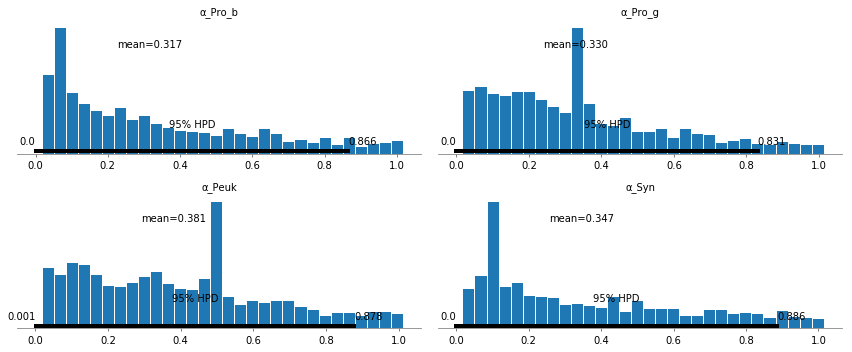

In [115]:
pm.plot_posterior(trace, varnames=['α_Pro_b', 'α_Pro_g', 
                                   'α_Peuk', 'α_Syn']);

In [116]:
df_trace = pm.trace_to_dataframe(trace, varnames=['α_Pro_b', 'α_Pro_g', 
                                   'α_Peuk', 'α_Syn'])

In [117]:
import matplotlib.pyplot as pl

(array([ 29., 471., 448., 348., 277., 202., 130.,  67.,  18.,  10.]),
 array([0.35984073, 0.64654682, 0.93325291, 1.219959  , 1.50666509,
        1.79337118, 2.08007728, 2.36678337, 2.65348946, 2.94019555,
        3.22690164]),
 <a list of 10 Patch objects>)

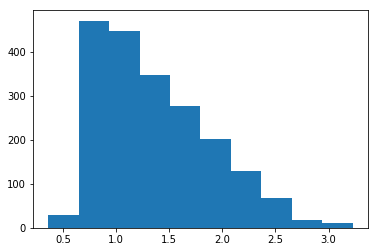

In [118]:
pl.hist(df_trace.sum(axis=1))